In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import lmfit

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
# only S21 dBm has factor of 20, otherwise it'd be a factor of 10
# this is because P = V^2/R, so the V^2 gives an extra factor of 2

def s21_dB_to_lin(dbm_ampl):
    return np.log10(dbm_ampl) * 20  

def s21_lin_to_dB(lin_ampl):
    return 10**(lin_ampl/20)

def load_csv(path):
    """
    Load a CSV file containing frequency, amplitude, and phase data into arrays and a pandas DataFrame.

    The function performs the following steps:
    1. Loads the CSV file into a pandas DataFrame.
    2. Extracts the '# Freq' column into an array of frequencies.
    3. Extracts the 'dB' column into an array of amplitudes.
    4. Extracts the 'Ang' column into an array of initial phases.
    5. Checks if the phases are in degrees or radians and unwraps them accordingly.
    6. Converts logarithmic amplitudes and unwrapped phases into complex data.

    Args:
        path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - freqs (numpy.ndarray): An array of frequencies.
            - cmplx (numpy.ndarray): An array of complex data representing the amplitudes and phases.
            - df (pandas.DataFrame): The original pandas DataFrame loaded from the CSV file.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(path)

    #Load pandas DataFrame columns into arrays
    freqs = df['# Freq'].to_numpy()
    amps = df['dB'].to_numpy()
    phases_init = df['Ang'].to_numpy()

    #Check if phases are in degrees. Unwrap phases.
    max_phase_value = np.max(phases_init)
    min_phase_value = np.min(phases_init)
    if (max_phase_value > 2 * np.pi) or (min_phase_value < -2 * np.pi): #check if phases are in degrees or radians, convert as needed
        #phases are in degrees, we need to convert
        phases_new = np.unwrap(np.deg2rad(phases_init))
    else:
        #phases are in radians, good to go
        phases_new = np.unwrap(phases_init)

    #Convert logarithmic amplitudes and phases into complex data
    cmplx = amps * np.exp(1j*phases_new)

    return freqs, cmplx, df

def load_all_csvs_in_path(path, key='*', idx=None):
    """AI is creating summary for load_all_csvs_in_path

    Args:
        path ([type]): [description]
        key (str, optional): [description]. Defaults to '*'.
        idx ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    data_files = glob.glob(path+chosen_files)
    
    if idx is not None:  # user wants to load a single file from dir
        idx = 0 if len(data_files) == 1 else idx  # set idx to 0 if there's only one file
        file = data_files[idx]
        df = pd.read_csv(file, sep=",", names=['Frequency','dB','Phase'])
        freq = np.array(df['Frequency'])
        ampl = s21_lin_to_dB(df['dB'])
        phase = np.unwrap(np.deg2rad(df['Phase']))
        cmplx = ampl * np.exp(1j*phase)
        
        return freq, cmplx, df
    
    elif idx is None and len(data_files) != 1:  
        freq_dict, cmplx_dict, df_dict = {}, {}, {}
        for filepath in data_files:
            filename = os.path.basename(filepath)
            df = pd.read_csv(filepath, sep=",", names=['Frequency','dB','Phase'])
            freq = np.array(df['Frequency'])
            ampl = s21_lin_to_dB(df['dB'])
            phase = np.unwrap(np.deg2rad(df['Phase']))
            cmplx = ampl * np.exp(1j*phase)
            
            freq_dict[filename] = freq
            cmplx_dict[filename] = cmplx
            df_dict[filename] = df
            
        return freq_dict, cmplx_dict, df_dict
        
    else:
        # idx is None and len(data_files) == 1
        print(f"idx={idx}, len(data_files)={len(data_files)}\n failed if & elif")
        raise
        

# load data from sample directory
data_path = 'test_data/sample_data.csv'
display(glob.glob(data_path))
freq, cmplx, df = load_csv(data_path)

print(freq, "\n", cmplx)


['test_data/sample_data.csv']

[4.51238120e+09 4.51240620e+09 4.51243120e+09 4.51245620e+09
 4.51248120e+09 4.51248120e+09 4.51248245e+09 4.51248370e+09
 4.51248495e+09 4.51248620e+09 4.51248745e+09 4.51248870e+09
 4.51248995e+09 4.51249120e+09 4.51249245e+09 4.51249370e+09
 4.51249495e+09 4.51249620e+09 4.51249745e+09 4.51249870e+09
 4.51249995e+09 4.51250120e+09 4.51250245e+09 4.51250370e+09
 4.51250495e+09 4.51250620e+09 4.51250745e+09 4.51250870e+09
 4.51250995e+09 4.51251120e+09 4.51251245e+09 4.51251370e+09
 4.51251495e+09 4.51251620e+09 4.51251745e+09 4.51251870e+09
 4.51251995e+09 4.51252120e+09 4.51252245e+09 4.51252370e+09
 4.51252495e+09 4.51252620e+09 4.51252745e+09 4.51252870e+09
 4.51252995e+09 4.51253120e+09 4.51253120e+09 4.51255620e+09
 4.51258120e+09 4.51260620e+09 4.51263120e+09] 
 [-1.88008582+3.2487959j  -1.86811469+3.26733659j -1.85207172+3.29818143j
 -1.82601965+3.36676151j -1.77568359+3.61536268j -1.777542  +3.61360335j
 -1.77403873+3.64010812j -1.76925126+3.67351878j -1.76794117+3.70658352j


## Testing scresonators

In [4]:
cur_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(cur_dir))

#For Zach
# this notebook is located in C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9/scresonators/test
# so the parent's parent directory is C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9
# and by adding that to our path, we can import C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9

#For Jorge
# this notebook is located in E:/GitHub/scresonators/test_ontebooks
# so the parent's parent directory is just E:/GitHub
# and by adding that to our path, we can import E:/GitHub/scresonators
sys.path.append(parent_parent_dir)
print(os.getcwd())

import scresonators.src as scres
print("\nimported scresonators!\n")


def print_dir(module, filter_underscore=True, text=""):
    if filter_underscore == True:
        print("showing dir({})".format(text))
        display( [i for i in dir(module) if '__' not in i] ) ## Display a list of modules if a dunder (double underscore) method like "__init__" is not included in the directory of the module?
    else:
        print("showing dir({})".format(text))
        display( dir(module) )


print_dir(scres.fit_methods.dcm, True, "src.fit_methods.dcm")
print_dir(scres.fit_methods.dcm.DCM, True, "src.fit_methods.dcm.DCM")

dcm_method = scres.fit_methods.dcm.DCM() ## Making an instance of DCM class. 
FitRes = scres.Fitter(dcm_method) ## Making instance of Fitter class.
## if I wanted to use kwargs: FitRes = scres.Fitter(dcm_method, preprocess='something_else')

w1 = freq[np.abs(cmplx).argmax()]
init_guess = {
    'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
    'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_params = lmfit.create_params(**init_guess) # supplying each key and their values as kwargs
# * is for a list, ** is for a dictionary. These are unpacking operators. 
init_params.pretty_print() # method of params instance. params consists of parameter objects. This is the thing underneath where it says WARNING:root...
print() ## == print("\n") 

# underneath this table of parameters, we see stuff from 'verbose = True' starting with [[Model]]

amps = np.abs(cmplx)
db_amps = np.log10(amps) * 20

phases = np.angle(cmplx)
result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True) ## set verbose=True if you want extra outputs

fit_result_params = result.params


c:\Users\zachm\OneDrive\Documents\GitHub\zachmiles9\scresonators\test

imported scresonators!

showing dir(src.fit_methods.dcm)


['DCM', 'FitMethod', 'find_circle', 'lmfit', 'np']

showing dir(src.fit_methods.dcm.DCM)


['_abc_impl', 'create_model', 'find_initial_guess', 'func']

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+06     1000    1e+09     None     True     None     None
Qc      1e+05     1000    1e+09     None     True     None     None
phi      0.08   -1.571    1.571     None     True     None     None
w1   4.513e+09 4.513e+09 4.513e+09     None     True     None     None

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 557
    # data points      = 102
    # variables        = 4
    chi-square         = 5.29443116
    reduced chi-square = 0.05402481
    Akaike info crit   = -293.748361
    Bayesian info crit = -283.248470
    R-squared          = (-2.114393344699128+0.005871902050345814j)
[[Variables]]
    Q:    1.0000e+09 +/- 9.7918e+10 (9791.83%) (init = 1000000)
    Qc:   6.0584e+08 +/- 2.6423e+10 (4361.28%) (init = 100000)
    w1:   4.5125e+09 +/- 227.120564 (0.00%) (init = 4.512506e+09)
    phi: -1.57079632 +/- 31.7543953 (2021.55%) (init = 0.08)
[[Correl

c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=-0.41278343497662034 < 1e-05 at iteration 4 and prob(Q=199999822.312647) = 0.5034099255333112 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(Q=1000000000.0) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=-0.05965545350784063 < 1e-05 at iteration 4 and prob(Qc=121168753.2746244) = 0.9333587300702516 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(Qc=1000000000.0) = 0.5498495807405359 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(w1=4512508922.496298) = 0.0 < max(sigmas)
  war

        99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Q  :      -inf      -inf      -inf999999111.56324      +inf      +inf      +inf
 Qc :      -inf      -inf-293640560.05157605843766.37312      +inf      +inf      +inf
 w1 :-436.01958-262.64948 -45.939614512508695.37573      +inf      +inf      +inf
 phi:      -inf      -inf      -inf  -1.57080  +0.32093      +inf      +inf


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+09     1000    1e+09 9.792e+10     True     None     None
Qc   6.058e+08     1000    1e+09 2.642e+10     True     None     None
phi    -1.571   -1.571    1.571    31.75     True     None     None
w1   4.513e+09 4.513e+09 4.513e+09    227.1     True     None     None
9791.828826148832 999999111.5632359 97918201267.28116

abs(data):  [3.75358462 3.76368713 3.78261423 3.8300693  4.02789021 4.02713108
 4.04939508 4.07737541 4.10662603 4.14317369 4.18508911 4.23200369
 4.28864336 4.3570528  4.43881893 4.53828812 4.65685368 4.80722666
 4.99126196 5.22016239 5.49543762 5.83798552 6.23918009 6.65456676
 7.00863886 7.16699219 7.03560114 6.66201591 6.17604542 5.69223976
 5.27912951 4.94617844 4.68491602 4.48620081 4.33550501 4.2211318
 4.1295352  4.05858088 4.00009346 3.95349479 3.91345739 3.88221002
 3.85621762 3.83441734 3.81488919 3.79981899 3.79974532 3.70641208
 3.69626594 3.69593501 3.69640374]
abs(result):  

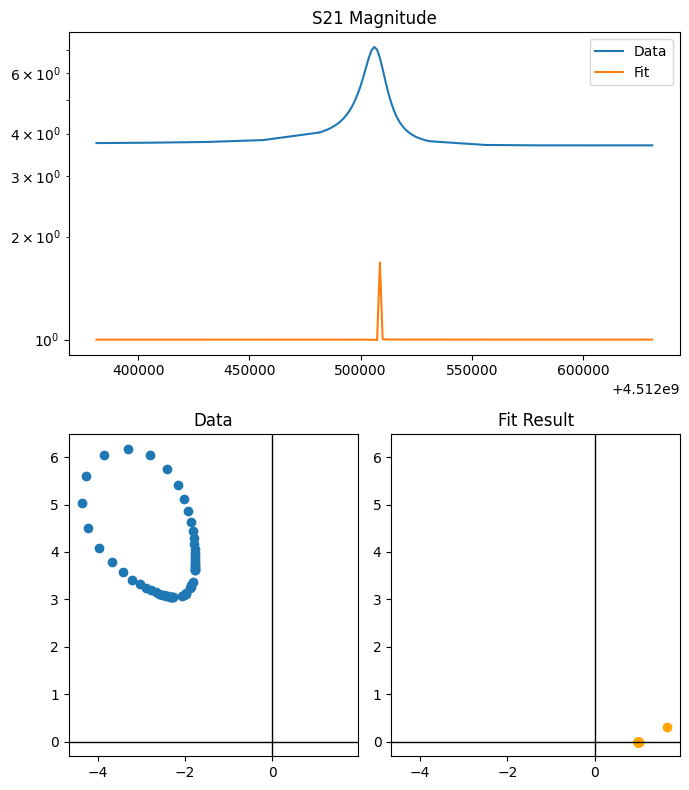

In [5]:
fit_result_params.pretty_print()

y_fit = result.eval(params=fit_result_params, x=freq)
# y_fit_err = result.eval_uncertainty()
Q_val = fit_result_params["Q"].value
Q_err = fit_result_params["Q"].stderr
dQ = 100 * Q_err/Q_val
print(dQ, Q_val, Q_err)

print("\nabs(data): ", np.abs(cmplx))
print("abs(result): ", np.abs(y_fit))

##########################################
#############    plotting   ##############
##########################################

mosaic = "AAAA\n BBCC"
fig, axes = plt.subplot_mosaic(mosaic, figsize=(7,8))
ax1, ax2, ax3 = axes["A"], axes["B"], axes["C"]
ax2.sharex(ax3)
ax2.sharey(ax3)

ax1.plot(freq, np.abs(cmplx), label="Data")
ax1.plot(freq, np.abs(y_fit), label="Fit")
ax1.set_yscale("log")
ax1.legend()
ax1.set_title("S21 Magnitude")

ax2.plot(np.real(cmplx), np.imag(cmplx), label="Data", linestyle='', marker='o')
ax2.set_title("Data")

ax2.axhline(y=0, color='black', linewidth=1)
ax2.axvline(x=0, color='black', linewidth=1)

ax3.plot(np.real(y_fit), np.imag(y_fit), label="Fit", linestyle='', marker='o', color='orange')
ax3.set_title("Fit Result")

ax3.axhline(y=0, color='black', linewidth=1)
ax3.axvline(x=0, color='black', linewidth=1)


fig.tight_layout()

## Multiple Resonators

to be implemented

In [6]:
# # load data from Andre
# data_dir = './samples/R0_Jorge/'
# chosen_files = '*'

# freq_dict, cmplx_dict = load_csv(data_dir, chosen_files, idx=None)

# dQ_list, Q_list = [], []

# print(f"# of resonators: {len(freq_dict)}")

# for freq, cmplx in zip(freq_dict.values(), cmplx_dict.values()):

#     FitRes = scres.Fitter(scres.fit_methods.DCM)

#     w1 = freq[np.abs(cmplx).argmin()]
#     init_guess = {
#         'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
#         'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
#         'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
#         'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
#     }

#     init_params = lmfit.create_params(**init_guess)

#     amps = np.abs(cmplx)
#     db_amps = np.log10(amps) * 20

#     phases = np.angle(cmplx)
#     result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True)

#     fit_params = result.params
        
#     y_fit = result.eval(params=fit_params, x=freq)
#     # y_fit_err = result.eval_uncertainty()
#     Q_val = fit_params["Q"].value
#     Q_err = fit_params["Q"].stderr
#     dQ = 100 * Q_err/Q_val
#     print(dQ, Q_val, Q_err)
    
#     dQ_list.append(dQ)
#     Q_list.append(Q_val)


    

In [7]:
# for dQ, Q in zip(dQ_list, Q_list):
    
#     print(f"{dQ:1.2f}, {Q:1.2f}")

# fig, axes = plt.subplots(2,1, figsize=(7,8), sharex=True)
# ax1, ax2 = axes[0], axes[1]

# ax1.plot(dQ_list, 'ro', label="dQ")
# ax1.set_title(r"dQ Values  ($dQ=100 * dQ/\sigma dQ$)")

# ax2.plot(Q_list, 'bo', label="Fit")
# ax2.set_title("Q Values")

# ax2.set_xlabel("Resonator #")